Image Segmentation과 Image Classification의 차이

Segmentation은 이미지의 특정 영역을 라벨링 하여 '자전거'를 타고 있는 '사람'처럼  표현하고자 하는 모델링

Segmentation은 이미지를 입력받아 이미지의 픽셀에 대한 카테고리를 출력하지만,

Classification은 이미지를 입력받아 이미지 하나에 대한 카테고리를 출력

https://m.blog.naver.com/9709193/221979612209 참고

# U-Net

U자 모양으로 생긴 U-Net은 의료 이미지 특성상 적은 수의 데이터로도 정확한 Segmentation이 가능

# 폐 영역분할

다음의 2019 대한의료인공지능학회 Summer School에서 진행한 AI hands-on의 자료에서 코드르 가져와서 수정함.

https://github.com/mi2rl/ai_handson/blob/master/KoSAIM_Summer_School_2019_Handson_03_Segmentation.ipynb


## 폐 데이터 다운로드

다음에서 다운받은 데이터

https://www.kaggle.com/nikhilpandey360/lung-segmentation-from-chest-x-ray-dataset

In [ ]:
!rm -rf Lung_Segmentation.zip
!wget https://github.com/dhrim/MDC_2021/raw/master/material/deep_learning/Lung_Segmentation.zip

--2022-01-03 13:44:10--  https://github.com/dhrim/MDC_2021/raw/master/material/deep_learning/Lung_Segmentation.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dhrim/MDC_2021/master/material/deep_learning/Lung_Segmentation.zip [following]
--2022-01-03 13:44:10--  https://raw.githubusercontent.com/dhrim/MDC_2021/master/material/deep_learning/Lung_Segmentation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37648324 (36M) [application/zip]
Saving to: ‘Lung_Segmentation.zip’

Lung_Segmentation.z 100%[===================>]  35.90M  --.-KB/s    in 0.1s    

2022-01-03 13:44:11 (287 MB/s) -

In [ ]:
!rm -rf Lung_Segmentation
!unzip Lung_Segmentation.zip

Archive:  Lung_Segmentation.zip
   creating: Lung_Segmentation/
   creating: Lung_Segmentation/image/
  inflating: Lung_Segmentation/image/CHNCXR_0001_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0002_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0003_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0004_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0005_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0006_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0007_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0008_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0009_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0010_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0011_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0012_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0013_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0014_0.png  
  inflating: Lung_Segmentation/image/CHNCXR_0015_0.png  
  inflating: Lung_Segmentation/image/CHNCXR

## 풀린 데이터 파일 구조

```
Lung_segmentaiton/
  image/
    CHNCXR_0001_0.png
    CHNCXR_0002_0.png
    ...
  label/
    CHNCXR_0001_0.png
    CHNCXR_0002_0.png
    ...
```

image와 label에 CHNCXR_0001_0.png 같은 이름의 사진이 있음

확인해보자

## 파일 보기

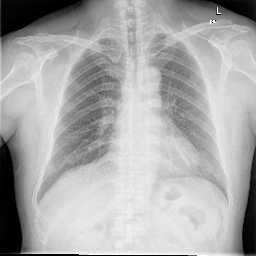

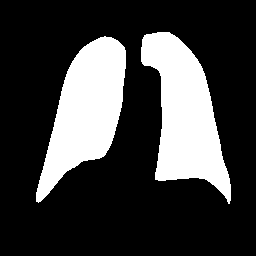

In [ ]:
from IPython.display import Image, display

display(Image('./Lung_Segmentation/image/CHNCXR_0001_0.png'))
display(Image('./Lung_Segmentation/label/CHNCXR_0001_0.png'))


## 데이터 로딩

In [ ]:
data_path = "Lung_Segmentation"
import os
print(os.path.join(data_path, 'image'))

Lung_Segmentation/image


In [ ]:
# data_path = "./Lung_Segmentation"
# import os
# print(os.path.join(data_path, 'image'))

In [ ]:
import numpy as np
import os

from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

data_path = "Lung_Segmentation"

files = os.listdir(os.path.join(data_path, 'image'))
file_headers = []  #python list
for f in files:
    f1 = os.path.splitext(f)[0]
    file_headers.append(f1)

# file_headers = ['CHNCXR_0402_1', 'CHNCXR_0461_1', 'CHNCXR_0422_1', ... ]    
# print(file_headers)

raw_x = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
raw_y = np.zeros((len(file_headers), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

count = 0
for fh in file_headers:
    # fh = "CHNCXR_0402_1"

    # f1 = "./Lung_Segmentation/image/CHNCXR_0402_1.png"
    f1 = os.path.join(data_path, 'image', '{}.png'.format(fh))
    # l1 = "./Lung_Segmentation/label/CHNCXR_0402_1.png"
    l1 = os.path.join(data_path, 'label', '{}.png'.format(fh))
    
    img = imread(f1)[:,:,:IMG_CHANNELS]
    # img.shape = (256, 256, 3)

    mask = imread(l1)
    # mask.shape = (256, 256)

    mask = np.expand_dims(mask, axis=-1)
    # mask.shape = (256, 256, 1)

    raw_x[count] = img
    raw_y[count] = mask
    
    count += 1


## 원시 데이터 보기

In [ ]:
print(raw_x.shape)
print(raw_y.shape)

(566, 256, 256, 3)
(566, 256, 256, 1)


In [ ]:
print(raw_x[0])
print(raw_y[0])

[[[ 75  75  75]
  [ 37  37  37]
  [ 28  28  28]
  ...
  [ 46  46  46]
  [ 54  54  54]
  [ 62  62  62]]

 [[ 73  73  73]
  [ 35  35  35]
  [ 24  24  24]
  ...
  [ 45  45  45]
  [ 50  50  50]
  [ 53  53  53]]

 [[ 72  72  72]
  [ 32  32  32]
  [ 20  20  20]
  ...
  [ 42  42  42]
  [ 45  45  45]
  [ 50  50  50]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 42  42  42]
  [ 42  42  42]
  [ 56  56  56]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 70  70  70]
  [ 71  71  71]
  [ 79  79  79]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [109 109 109]
  [111 111 111]
  [112 112 112]]]
[[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [F

## 데이터 정규화

In [ ]:
x_all = raw_x.astype('float32') / 255.
y_all = raw_y

## 데이터 나누기

In [ ]:
split_index = int(x_all.shape[0]*0.8)
train_x, test_x = x_all[:split_index], x_all[split_index:]
train_y, test_y = y_all[:split_index], y_all[split_index:]

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(452, 256, 256, 3)
(452, 256, 256, 1)
(114, 256, 256, 3)
(114, 256, 256, 1)


train


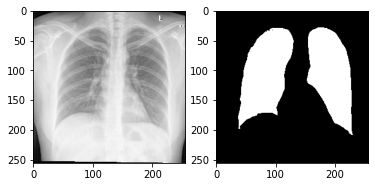

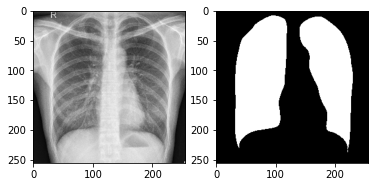

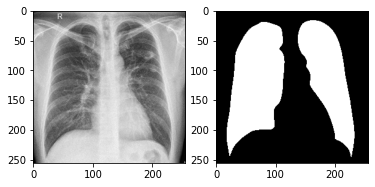

test


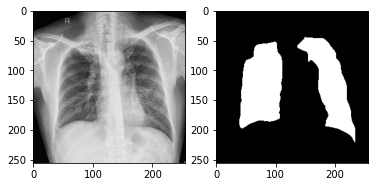

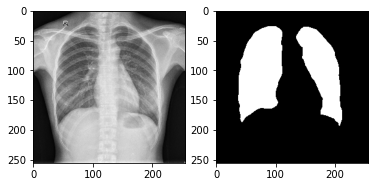

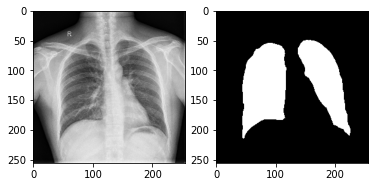

In [ ]:
import matplotlib.pyplot as plt

def plotTrainData(x, y, set_type):
    print(set_type)  
    for i in range(3):
        ix = np.random.randint(0, len(x))
        plt.subplot(1,2,1)
        plt.imshow(x[ix])
        
        plt.subplot(1,2,2)
        plt.imshow(np.squeeze(y[ix]), 'gray') # np.squeeze()는 (256,26,1)을 (256,256)으로 변환
        plt.show()
        
plotTrainData(train_x, train_y, 'train')
plotTrainData(test_x, test_y, 'test')

## U-Net 모델 정의

Biomedical 분야에서 이미지 분할(Image Segmentation)을 목적으로 제안된 End-to-End 방식의 Fully-Convolutional Network 기반 모델

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    # 줄어든 이미지를 다시 원이미지로 키울 때 사용
    up = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)   # 이미지 2배 키워줌?
    up6 = concatenate([up, conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up, conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up, conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = concatenate([up, conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

## 모델 컴파일과 학습

In [ ]:
# 모델 생성
model = unet()

# 모델 컴파일
model.compile(loss="mse", optimizer="SGD", metrics=['accuracy'])

# 학습
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=20, batch_size=8, verbose=1)


Epoch 1/20
46/46 [==============================] - 26s 247ms/step - loss: 0.1984 - accuracy: 0.7397 - val_loss: 0.2059 - val_accuracy: 0.7400
Epoch 2/20
46/46 [==============================] - 8s 168ms/step - loss: 0.1581 - accuracy: 0.8039 - val_loss: 0.1903 - val_accuracy: 0.7375
Epoch 3/20
46/46 [==============================] - 8s 169ms/step - loss: 0.1271 - accuracy: 0.8447 - val_loss: 0.1873 - val_accuracy: 0.7318
Epoch 4/20
46/46 [==============================] - 8s 170ms/step - loss: 0.0958 - accuracy: 0.8878 - val_loss: 0.2097 - val_accuracy: 0.6740
Epoch 5/20
46/46 [==============================] - 8s 171ms/step - loss: 0.0789 - accuracy: 0.9095 - val_loss: 0.2438 - val_accuracy: 0.6517
Epoch 6/20
46/46 [==============================] - 8s 171ms/step - loss: 0.0672 - accuracy: 0.9234 - val_loss: 0.2291 - val_accuracy: 0.6840
Epoch 7/20
46/46 [==============================] - 8s 173ms/step - loss: 0.0601 - accuracy: 0.9310 - val_loss: 0.1954 - val_accuracy: 0.7234
Epoch

## 학습시 로스와 정확도 보기

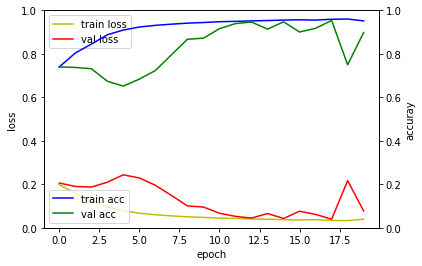

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 테스트 결과 보기

In [ ]:
import matplotlib.pyplot as plt

def plotPredictions(model, train_x, train_y, test_x, test_y):

    ix = np.random.randint(0, len(train_x))

    input_ = train_x[ix:ix+1]
    mask_ = train_y[ix:ix+1]

    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()

    ix = np.random.randint(0, len(test_x))
    input_ = test_x[ix:ix+1]
    mask_ = test_y[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')
    plt.show()

1/1 [==============================] - 0s 23ms/step - loss: 0.0464 - accuracy: 0.9423


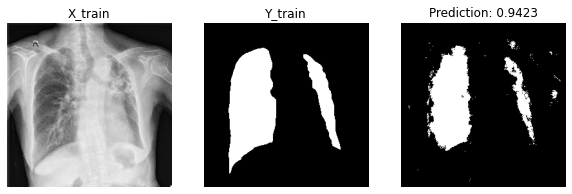

1/1 [==============================] - 0s 25ms/step - loss: 0.0335 - accuracy: 0.9587


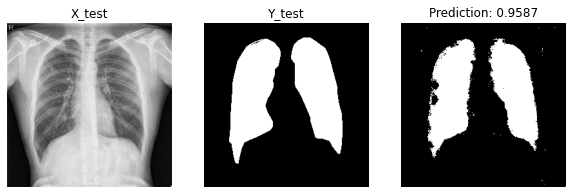

In [ ]:
plotPredictions(model, train_x, train_y, test_x, test_y)

# 학습량 늘려보기

In [ ]:
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=200, batch_size=8, verbose=1)

Epoch 1/200
46/46 [==============================] - 8s 177ms/step - loss: 0.0313 - accuracy: 0.9622 - val_loss: 0.0377 - val_accuracy: 0.9559
Epoch 2/200
46/46 [==============================] - 8s 179ms/step - loss: 0.0303 - accuracy: 0.9633 - val_loss: 0.0327 - val_accuracy: 0.9596
Epoch 3/200
46/46 [==============================] - 8s 174ms/step - loss: 0.0297 - accuracy: 0.9640 - val_loss: 0.0353 - val_accuracy: 0.9580
Epoch 4/200
46/46 [==============================] - 8s 176ms/step - loss: 0.0289 - accuracy: 0.9649 - val_loss: 0.0351 - val_accuracy: 0.9586
Epoch 5/200
46/46 [==============================] - 8s 178ms/step - loss: 0.0282 - accuracy: 0.9657 - val_loss: 0.0309 - val_accuracy: 0.9630
Epoch 6/200
46/46 [==============================] - 8s 180ms/step - loss: 0.0274 - accuracy: 0.9666 - val_loss: 0.0290 - val_accuracy: 0.9639
Epoch 7/200
46/46 [==============================] - 8s 181ms/step - loss: 0.0266 - accuracy: 0.9675 - val_loss: 0.0292 - val_accuracy: 0.9653

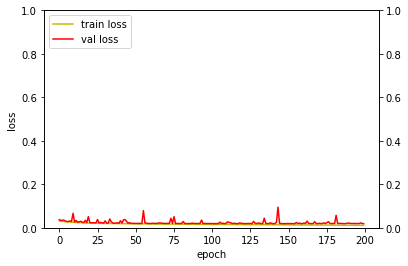

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.0])

# acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')     # OUT <----------
# acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')     # OUT <----------
# acc_ax.set_ylim([0.0, 1.0])     # OUT <----------

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuray')     # OUT <----------

loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')     # OUT <----------

plt.show()

1/1 [==============================] - 0s 31ms/step - loss: 0.0253 - accuracy: 0.9694


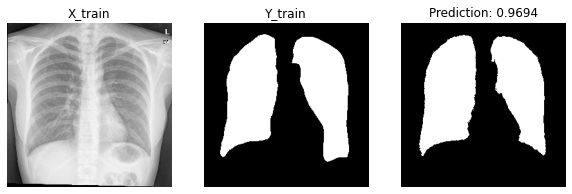

1/1 [==============================] - 0s 28ms/step - loss: 0.0116 - accuracy: 0.9854


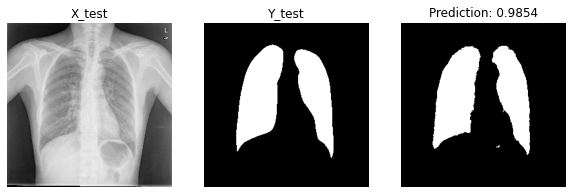

In [ ]:
plotPredictions(model, train_x, train_y, test_x, test_y)

# TODO
```
- epoch 200
- 동적으로 로스 그리기
- best 모델 저장
- 학습 후 best 모델 로딩해서 결과 그리기
```

In [ ]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):
    self.epochs = []
    self.losses = []
    self.val_losses = []
    self.logs = []
    self.fig = plt.figure()


  def on_epoch_end(self, epoch, logs={}):

    self.epochs.append(epoch)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    clear_output(wait=True)
    plt.plot(self.epochs, self.losses, label="loss")
    plt.plot(self.epochs, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])

In [ ]:
# 모델 생성
model = unet()

# 모델 컴파일
model.compile(loss="mse", optimizer="SGD", metrics=['accuracy'])


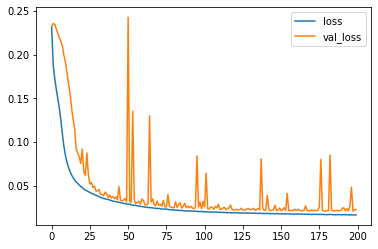

loss =  0.016549216583371162 , val_loss =  0.022493533790111542


In [ ]:
plot_losses = PlotLosses() 
model.fit(train_x, train_y, epochs=200, verbose=0, batch_size=20, validation_split=0.1, 
          callbacks=[plot_losses])


In [ ]:
# best 모델 저장
from tensorflow.keras.callbacks import ModelCheckpoint
model_check_point = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True)

# 학습
model.fit(train_x, train_y, epochs=200, verbose=0, batch_size=20, validation_split=0.1, 
          callbacks=[model_check_point])

In [ ]:
import matplotlib.pyplot as plt

def plotPredictions(model, train_x, train_y, test_x, test_y):

    ix = np.random.randint(0, len(train_x))

    input_ = train_x[ix:ix+1]
    mask_ = train_y[ix:ix+1]

    preds_train = model.predict(input_) 
    preds_train_t = (preds_train > 0.5).astype(np.uint8)

    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_train_t[0][:,:,0], 'gray')
    plt.show()

    ix = np.random.randint(0, len(test_x))
    input_ = test_x[ix:ix+1]
    mask_ = test_y[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(input_[0])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(mask_[0][:,:,0], 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)  
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(preds_test_t[0][:,:,0], 'gray')
    plt.show()

In [ ]:
plotPredictions(model, train_x, train_y, test_x, test_y)  